# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [110]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [111]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [112]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((pp.scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((pp.scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.32404051, -0.10172788,  0.05706686,  1.58149633,  2.21667528,
         1.32742475, -0.00645104, -0.32404051],
       [-0.41931735, -0.26052262,  0.62872791,  2.02612159,  2.02612159,
         1.16863002, -0.19700472, -0.51459419],
       [-0.41931735, -0.32404051,  1.16863002,  1.89908581,  1.80380896,
         0.85104054, -0.32404051, -0.00645104],
       [-0.57811209, -0.19700472,  1.58149633,  2.02612159,  1.48621949,
        -0.00645104, -0.51459419, -0.32404051],
       [-0.32404051,  0.31113844,  1.16863002,  1.26390686,  0.12058475,
        -0.26052262, -0.57811209, -0.73690683],
       [-0.73690683,  0.31113844, -0.26052262,  0.85104054, -0.32404051,
        -0.73690683, -0.83218367, -1.14977314],
       [-1.21329104, -0.64162998, -0.95921946,  0.43817423, -0.57811209,
        -0.89570156, -1.14977314, -1.0544963 ],
       [-1.27680893, -1.21329104, -1.14977314, -0.89570156, -0.89570156,
        -1.0544963 , -1.27680893, -1.27680893]])

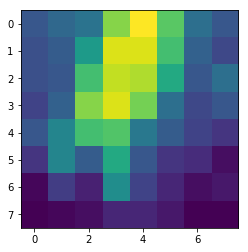

In [113]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [114]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 150)               19350     
__________

In [115]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

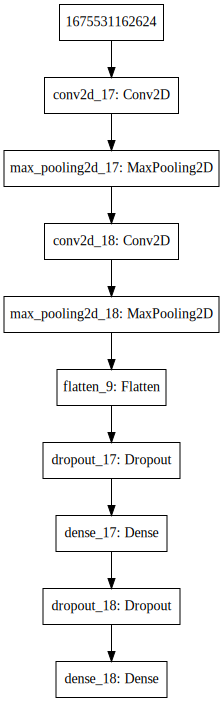

In [116]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [117]:
EPOCHS = 80
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/80
90/90 [==============================] - 1s 8ms/step - loss: 1.1214 - acc: 0.3444 - val_loss: 1.0606 - val_acc: 0.3333
Epoch 2/80
90/90 [==============================] - 0s 347us/step - loss: 1.1589 - acc: 0.4222 - val_loss: 1.0258 - val_acc: 0.7333
Epoch 3/80
90/90 [==============================] - 0s 332us/step - loss: 1.0460 - acc: 0.4556 - val_loss: 0.9914 - val_acc: 0.6667
Epoch 4/80
90/90 [==============================] - 0s 332us/step - loss: 1.0307 - acc: 0.4556 - val_loss: 0.9572 - val_acc: 0.8444
Epoch 5/80
90/90 [==============================] - 0s 355us/step - loss: 1.0169 - acc: 0.4667 - val_loss: 0.9364 - val_acc: 0.8222
Epoch 6/80
90/90 [==============================] - 0s 454us/step - loss: 0.9319 - acc: 0.6333 - val_loss: 0.8913 - val_acc: 0.7778
Epoch 7/80
90/90 [==============================] - 0s 288us/step - loss: 0.9555 - acc: 0.5222 - val_loss: 0.8701 - val_acc: 0.7333
Epoch 8/80
90/90 [================

90/90 [==============================] - 0s 188us/step - loss: 0.1054 - acc: 0.9667 - val_loss: 0.0290 - val_acc: 1.0000
Epoch 63/80
90/90 [==============================] - 0s 188us/step - loss: 0.0797 - acc: 0.9778 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 64/80
90/90 [==============================] - 0s 177us/step - loss: 0.0464 - acc: 0.9889 - val_loss: 0.0260 - val_acc: 1.0000
Epoch 65/80
90/90 [==============================] - 0s 188us/step - loss: 0.0939 - acc: 0.9667 - val_loss: 0.0275 - val_acc: 1.0000
Epoch 66/80
90/90 [==============================] - 0s 177us/step - loss: 0.0442 - acc: 0.9889 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 67/80
90/90 [==============================] - 0s 177us/step - loss: 0.0552 - acc: 0.9778 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 68/80
90/90 [==============================] - 0s 177us/step - loss: 0.0603 - acc: 0.9778 - val_loss: 0.0397 - val_acc: 1.0000
Epoch 69/80
90/90 [==============================] - 0s 188us/step - loss: 0.0543

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


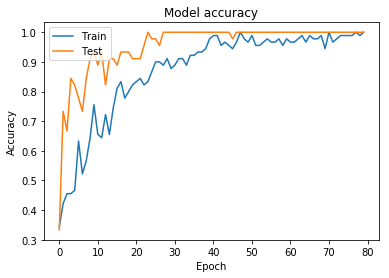

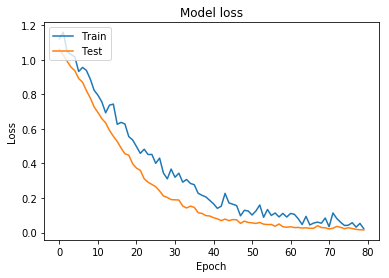

In [118]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [119]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_cnn_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [120]:
del model
model = models.load_model(filename)

## Confirmation

In [121]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 8, 8, 1)

In [122]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [123]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [124]:
class_labels

['paper', 'rock', 'scissors']

In [125]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 99,  0],
       [ 0,  3, 96],
       [ 0, 88, 10],
       [ 0,  0, 99],
       [98,  0,  1],
       [ 0, 99,  0],
       [ 0,  4, 95],
       [ 0, 99,  0],
       [ 0,  0, 99],
       [87,  0, 12]])

In [126]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [127]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

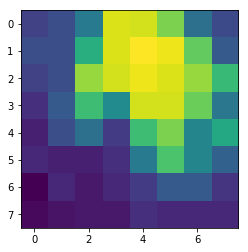

In [128]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

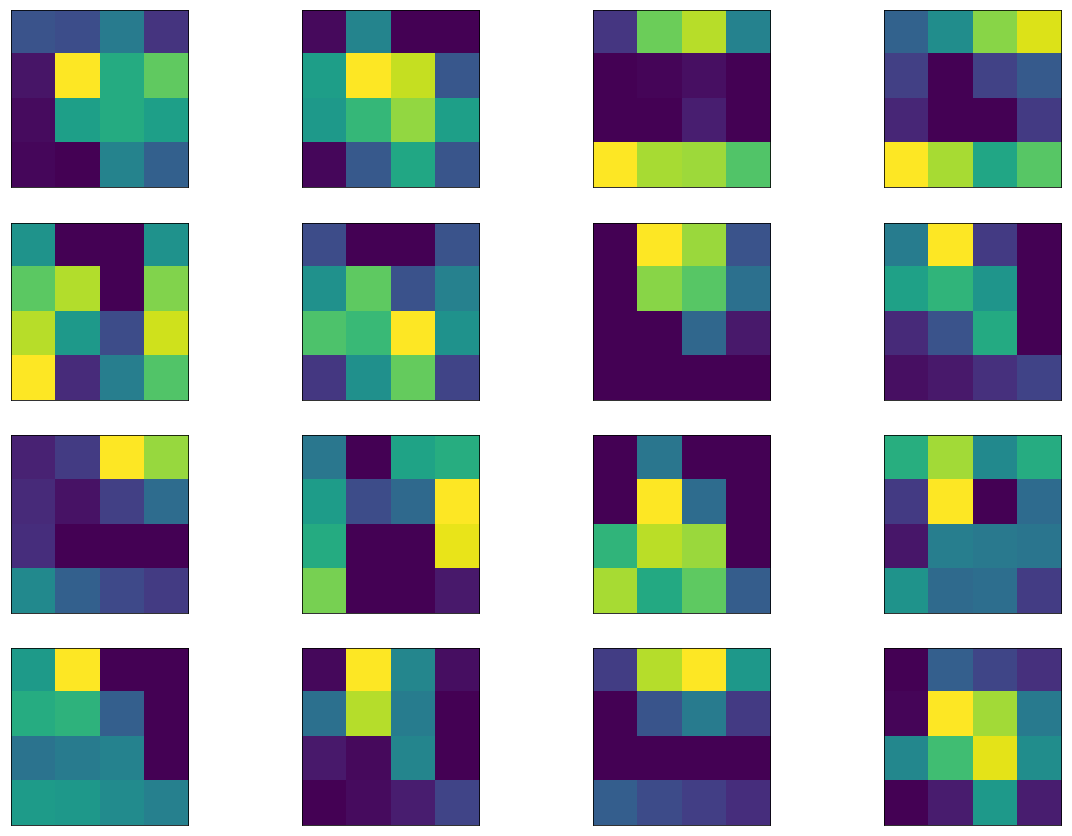

In [129]:
plot_layer(activations, image_number, 1)

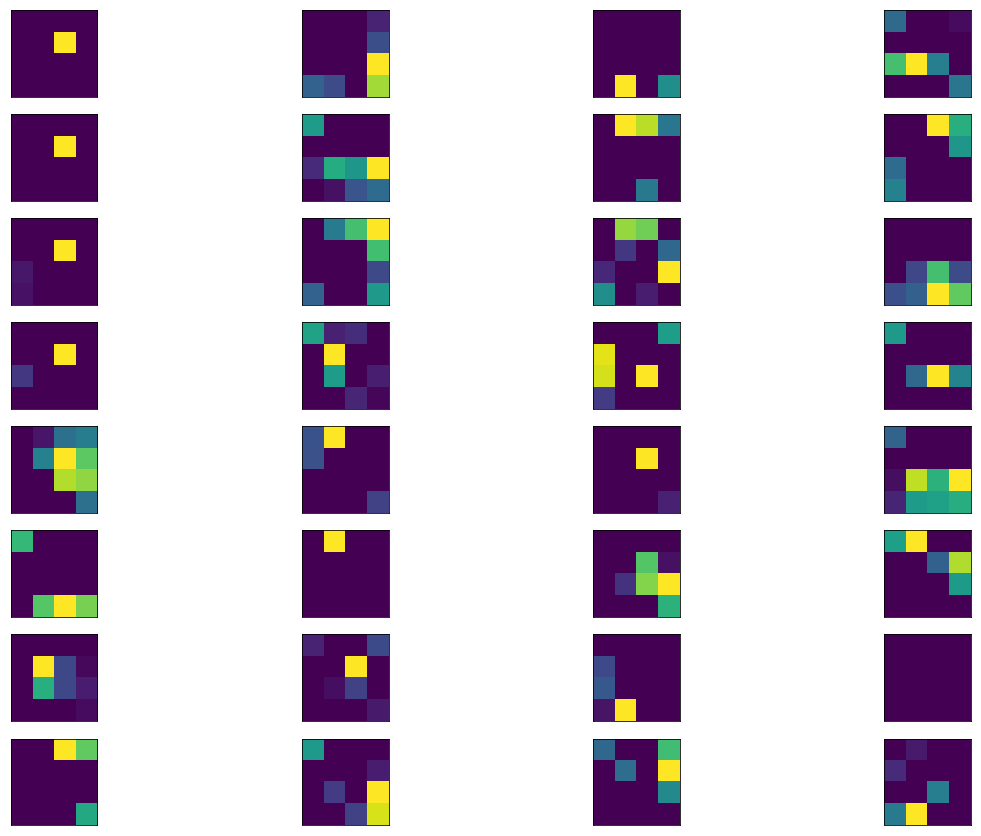

In [130]:
plot_layer(activations, image_number, 2)